In [1]:
# Imports here
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch
from torch import nn, optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
from PIL import Image, ImageFile
import json
from torch.optim import lr_scheduler
import seaborn as sns
import cv2
import os
import pandas as pd
from sklearn.metrics import confusion_matrix


In [2]:

# Load dataset and paths
train_csv = pd.read_csv('/home/gcekcse/Documents/ML_Project_hk/data/train.csv')
test_csv = pd.read_csv('/home/gcekcse/Documents/ML_Project_hk/data/test.csv')
base_dir = "/home/gcekcse/Documents/ML_Project_hk/data"
train_path = base_dir + "/train_images/"
test_path = base_dir + "/test_images/"


/tmp/ipykernel_1351675/2314874016.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, alpha=0.8, palette='bright')


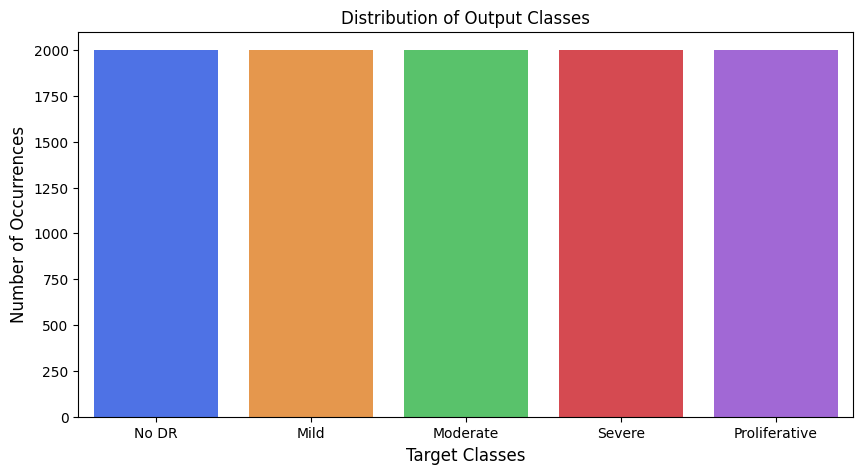

In [3]:

# Check image distribution
counts = train_csv['diagnosis'].value_counts()
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']
for i, x in enumerate(class_list):
    counts[x] = counts.pop(i)
plt.figure(figsize=(10, 5))
sns.barplot(x=counts.index, y=counts.values, alpha=0.8, palette='bright')
plt.title('Distribution of Output Classes')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Target Classes', fontsize=12)
plt.show()


In [4]:

# Dataset class
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir, transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name, label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name + '.png')
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB if needed
        if self.transform is not None:
            image = self.transform(image)
        return image, label


# Transforms
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [5]:

# Dataset loading
train_data = CreateDataset(df_data=train_csv, data_dir=train_path, transform=train_transforms)
test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)

# Data loaders
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = DataLoader(train_data, batch_size=64, sampler=train_sampler)
validloader = DataLoader(train_data, batch_size=64, sampler=valid_sampler)
testloader = DataLoader(test_data, batch_size=64)


In [6]:

# ResNet152 Model and fine-tuning
model = models.resnet152(pretrained=True)
num_ftrs = model.fc.in_features
out_ftrs = 5

model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Linear(512, out_ftrs),
    nn.LogSoftmax(dim=1)
)

# Loss, optimizer, scheduler
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Freezing layers
for name, child in model.named_children():
    if name in ['layer2', 'layer3', 'layer4', 'fc']:
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False


/home/gcekcse/hkenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gcekcse/hkenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:

# Train and test loop
def train_and_test(e):
    epochs = e
    train_losses, test_losses, acc = [], [], []
    valid_loss_min = np.Inf
    model.train()
    print("Model Training started.....")
    
    for epoch in range(epochs):
        running_loss = 0
        batch = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            batch += 1
            if batch % 10 == 0:
                print(f" epoch {epoch + 1} batch {batch} completed")
        
        test_loss, accuracy = 0, 0
        with torch.no_grad():
            model.eval()
            for images, labels in validloader:
                images, labels = images.to(device), labels.to(device)
                logps = model(images)
                test_loss += criterion(logps, labels)
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        train_losses.append(running_loss / len(trainloader))
        test_losses.append(test_loss / len(validloader))
        acc.append(accuracy)
        scheduler.step()
        
        print(f"Epoch: {epoch + 1}/{epochs}.. "
              f"Training Loss: {running_loss/len(trainloader):.3f}.. "
              f"Valid Loss: {test_loss/len(validloader):.3f}.. "
              f"Valid Accuracy: {accuracy/len(validloader):.3f}")
        
        if test_loss / len(validloader) <= valid_loss_min:
            torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()},
                       "/home/gcekcse/Documents/ML_Project_hk/data/models/classifier.pt")
            valid_loss_min = test_loss / len(validloader)
    print('Training Completed Succesfully !')
    return train_losses, test_losses, acc



#training

train_losses, valid_losses, acc = train_and_test(50)


# Plotting training curves
plt.plot(train_losses, label='train_loss')
plt.plot([x.cpu().numpy() for x in valid_losses], label='valid_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.show()

plt.plot([x.cpu().numpy() for x in acc], label='accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(frameon=False)
plt.show()


In [8]:
# Generate Confusion Matrix
def generate_confusion_matrix(model, dataloader):
    y_true, y_pred = [], []
    with torch.no_grad():
        model.eval()
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            logps = model(images)
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(top_class.cpu().numpy())
    
    cm = confusion_matrix(y_true, [x[0] for x in y_pred])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_list, yticklabels=class_list)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


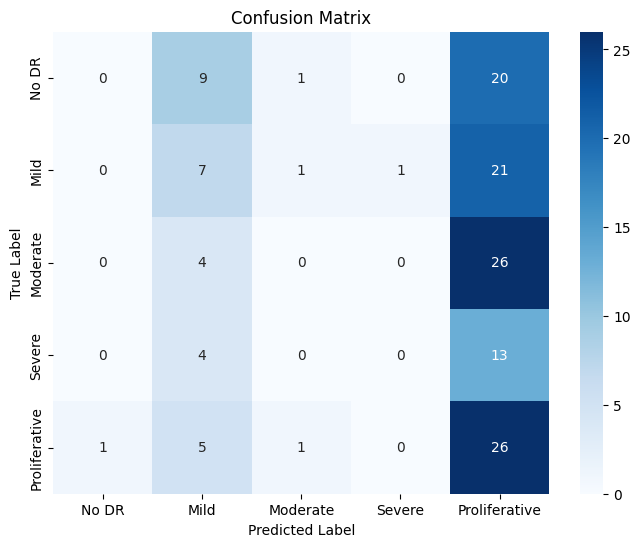

In [9]:
# Generate confusion matrix for the validation set
generate_confusion_matrix(model, testloader)

In [10]:
from sklearn.metrics import classification_report


In [ ]:
# Redefine the ResNet152 model architecture
model = models.resnet152(pretrained=False)  # Ensure 'pretrained=False' since you're loading your own weights
num_ftrs = model.fc.in_features
out_ftrs = 5  # Adjust to your number of output classes

# Modify the fully connected layer to match the output classes (5 in your case)
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Linear(512, out_ftrs),
    nn.LogSoftmax(dim=1)
)

# Load the saved model state
checkpoint = torch.load("/home/gcekcse/Documents/ML_Project_hk/data/models/classifier_ResNett152.pt")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set model to evaluation mode

# Generate classification report
def generate_classification_report(model, dataloader):
    y_true, y_pred = [], []
    with torch.no_grad():
        model.eval()
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            logps = model(images)
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(top_class.cpu().numpy())

    # Print classification report
    print(classification_report(y_true, [x[0] for x in y_pred], target_names=class_list))

# Generate classification report for the validation set
generate_classification_report(model, validloader)


/home/gcekcse/hkenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gcekcse/hkenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_1351675/3848671346.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. T

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define the class names (update if necessary)
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']

# Define the transformations (the same used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to classify an input image
def classify_image(image_path, model):
    # Load the image
    image = Image.open(image_path).convert("RGB")  # Ensure the image is in RGB mode
    image_tensor = transform(image)  # Apply transformations

    # Add batch dimension
    image_tensor = image_tensor.unsqueeze(0).to(device)

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():
        # Forward pass
        logps = model(image_tensor)
        ps = torch.exp(logps)  # Get probabilities
        top_p, top_class = ps.topk(1, dim=1)  # Get the top class

    # Get the predicted class and probability
    predicted_class = class_list[top_class.cpu().numpy()[0][0]]
    predicted_probability = top_p.cpu().numpy()[0][0]

    return predicted_class, predicted_probability, image

# Example usage
image_paths = [
    "/home/gcekcse/Documents/ML_Project_hk/data/my_images/1.jpeg",
    "/home/gcekcse/Documents/ML_Project_hk/data/my_images/2.jpeg",
    "/home/gcekcse/Documents/ML_Project_hk/data/my_images/3.jpeg"
]

# Loop through each image
for image_path in image_paths:
    predicted_class, predicted_probability, image = classify_image(image_path, model)
    
    # Display the image and the prediction
    plt.imshow(image)
    plt.title(f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.4f}')
    plt.axis('off')  # Hide axes
    plt.show()
